# Ionisation Profile Monitors

In [103]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import scienceplots

In [104]:
mcp_width = 0.5 #mm

#### Horizontal IPM

In [105]:
# Horizontal IPM
# Gaussian function for fit
def gaussian(x, amplitude, mean, std_dev, c):
    return amplitude * np.exp(-(x - mean)**2 / (2 * std_dev**2)) + c

def linear_func(x, a, b):
    return a * x + b

def mcp_H(skip=[],debug=False):
    Num = 100
    booster_turns = [6,8,10,11,14]
    Beam_Width = np.zeros((len(booster_turns),5))
    Intensity = np.zeros((len(booster_turns),5))
    
    Intensity_Avg = np.zeros(len(booster_turns))
    Intensity_Std = np.zeros(len(booster_turns))
    Beam_Width_Avg = np.zeros(len(booster_turns))
    Beam_Width_Std = np.zeros(len(booster_turns))

    for t, turns in enumerate(booster_turns):
        for repeat in range(5):
            if (str(turns)+"."+str(repeat)) in skip:
                continue
            # Calculate average intensity in the 0.04s around 0.57s

            try:
                intensity_data = np.loadtxt(r'C:\\Users\bengl\Documents\summerIntern\data_studies\\' + str(turns) + r'turns'+str(repeat)+'_beam')
                mask = (intensity_data[0:,0] > 0.55) & (intensity_data[0:,0] < 0.59)
                Averaged_Intensity = np.mean(intensity_data[0:,1][mask])
                Intensity[t][repeat] = Averaged_Intensity
            except:
                pass
                #print('no intensity data for', turns, 'turns', repeat, 'repeat')

            try:
                data = np.load(r'C:\\Users\bengl\Documents\summerIntern\data_studies\\incoherent_tune_shift\\'+str(turns)+r'turns'+str(repeat)+'_H.npy')
                position = np.arange(0,len(data[Num]),1) * mcp_width
            except:
                continue

            # Remove the faulty sensor
            mask = data[Num] > -2000
            filtered = data[Num][mask]
            position_filtered = position[mask]

            # Remove first few MCP points as faulty
            mask = position_filtered > 2.1
            filtered = filtered[mask]
            position_filtered = position_filtered[mask]

            # Fit a gaussian to the peak
            p0 = [5000, 15*mcp_width, 10*mcp_width, 0]  # Initial guess for the parameters
            lower_bounds = [0, 0, 0, -1000]
            upper_bounds = [15000, 100*mcp_width, 30*mcp_width, 1000]
            bounds = (lower_bounds, upper_bounds)
            fit_params, _ = curve_fit(gaussian, position_filtered, filtered, p0=p0, bounds=bounds)
            amplitude_fit, mean_fit, std_dev_fit, c_fit = fit_params
            fitted_curve = gaussian(position_filtered, amplitude_fit, mean_fit, std_dev_fit, c_fit)

            # Plotting
            if debug==True:
                plt.plot(position_filtered, filtered, label='Fourier Transformed Data')
                plt.plot(position_filtered, fitted_curve, label='Fitted Curve')
                plt.title('Position with ' + str(turns) + ' Booster Turns')
                plt.xlabel('Position')
                plt.ylabel('Amplitude')
                plt.legend()
                plt.show()
            
            
            # In case only one data point
            Beam_Width_Avg[t] = std_dev_fit            
            
            Beam_Width[t][repeat] = std_dev_fit

            if debug==True:
                print(str(turns)+"."+str(repeat))
            
          
    
    
    # Remove rows if no data for that booster turn        
    # Create a boolean mask indicating which rows contain all zeros
    mask = np.any(Intensity != 0, axis=1)

    # Use the mask to select the rows without all zeros
    Intensity = Intensity[mask]
    Beam_Width = Beam_Width[mask]
    Beam_Width_Avg = Beam_Width_Avg[mask]
    Beam_Width_Std = Beam_Width_Std[mask]
    Intensity_Avg = Intensity_Avg[mask]
    Intensity_Std = Intensity_Std[mask]

    for i in range(Intensity.shape[0]):
        I_list = Intensity[i,:][Intensity[i,:]>0]
        if len(I_list) == 1:
            continue
        else:
            Intensity_Std[i] = np.std(I_list)
            Intensity_Avg[i] = np.mean(I_list)

            list = Beam_Width[i,:][Beam_Width[i,:]>0]
            Beam_Width_Avg[i] = np.mean(list)
            Beam_Width_Std[i] = np.std(list)
    
    # Set the STD of the Intensity to the maximum of the others (if only one data point)
    for i in range(Intensity.shape[0]):
        I_list = Intensity[i,:][Intensity[i,:]>0]
        if len(I_list) == 1:
            print("Using max intensity error of others for turns", booster_turns[i])
            Intensity_Std[i]=max(Intensity_Std)
            Intensity_Avg[i]=I_list[0]

        list = Beam_Width[i,:][Beam_Width[i,:]>0]
        if len(list)==1:
            print("Using max frequency error of others for turns", booster_turns[i])
            Beam_Width_Std[i]=max(Beam_Width_Std)
            Beam_Width_Avg[i]=list[0]
          
    
    params, _ = curve_fit(linear_func, Intensity_Avg, Beam_Width_Avg)
    # Extract the fitted parameters
    a, b = params
    # Plot
    
    plt.style.use(['science','ieee'])
    fig, ax = plt.subplots(figsize=(5,3), dpi=800)
    plt.xlabel(r'E $\times 10^{12}$ (ppb)')
    plt.ylabel('Horizontal Beam Size (mm)')
    plt.title('Horizontal Beam Size vs Intensity')
    plt.errorbar(Intensity_Avg,Beam_Width_Avg,xerr=Intensity_Std,yerr=Beam_Width_Std, fmt='x', markersize=3, markeredgewidth=0.5, ecolor='black', capsize=2, elinewidth=0.5, capthick=0.5)
    plt.plot(Intensity_Avg,a*np.array(Intensity_Avg)+b, label='Linear Fit', color='red', linewidth=0.5)
    plt.show()


Non-weighted fitting for the following as error bars too small

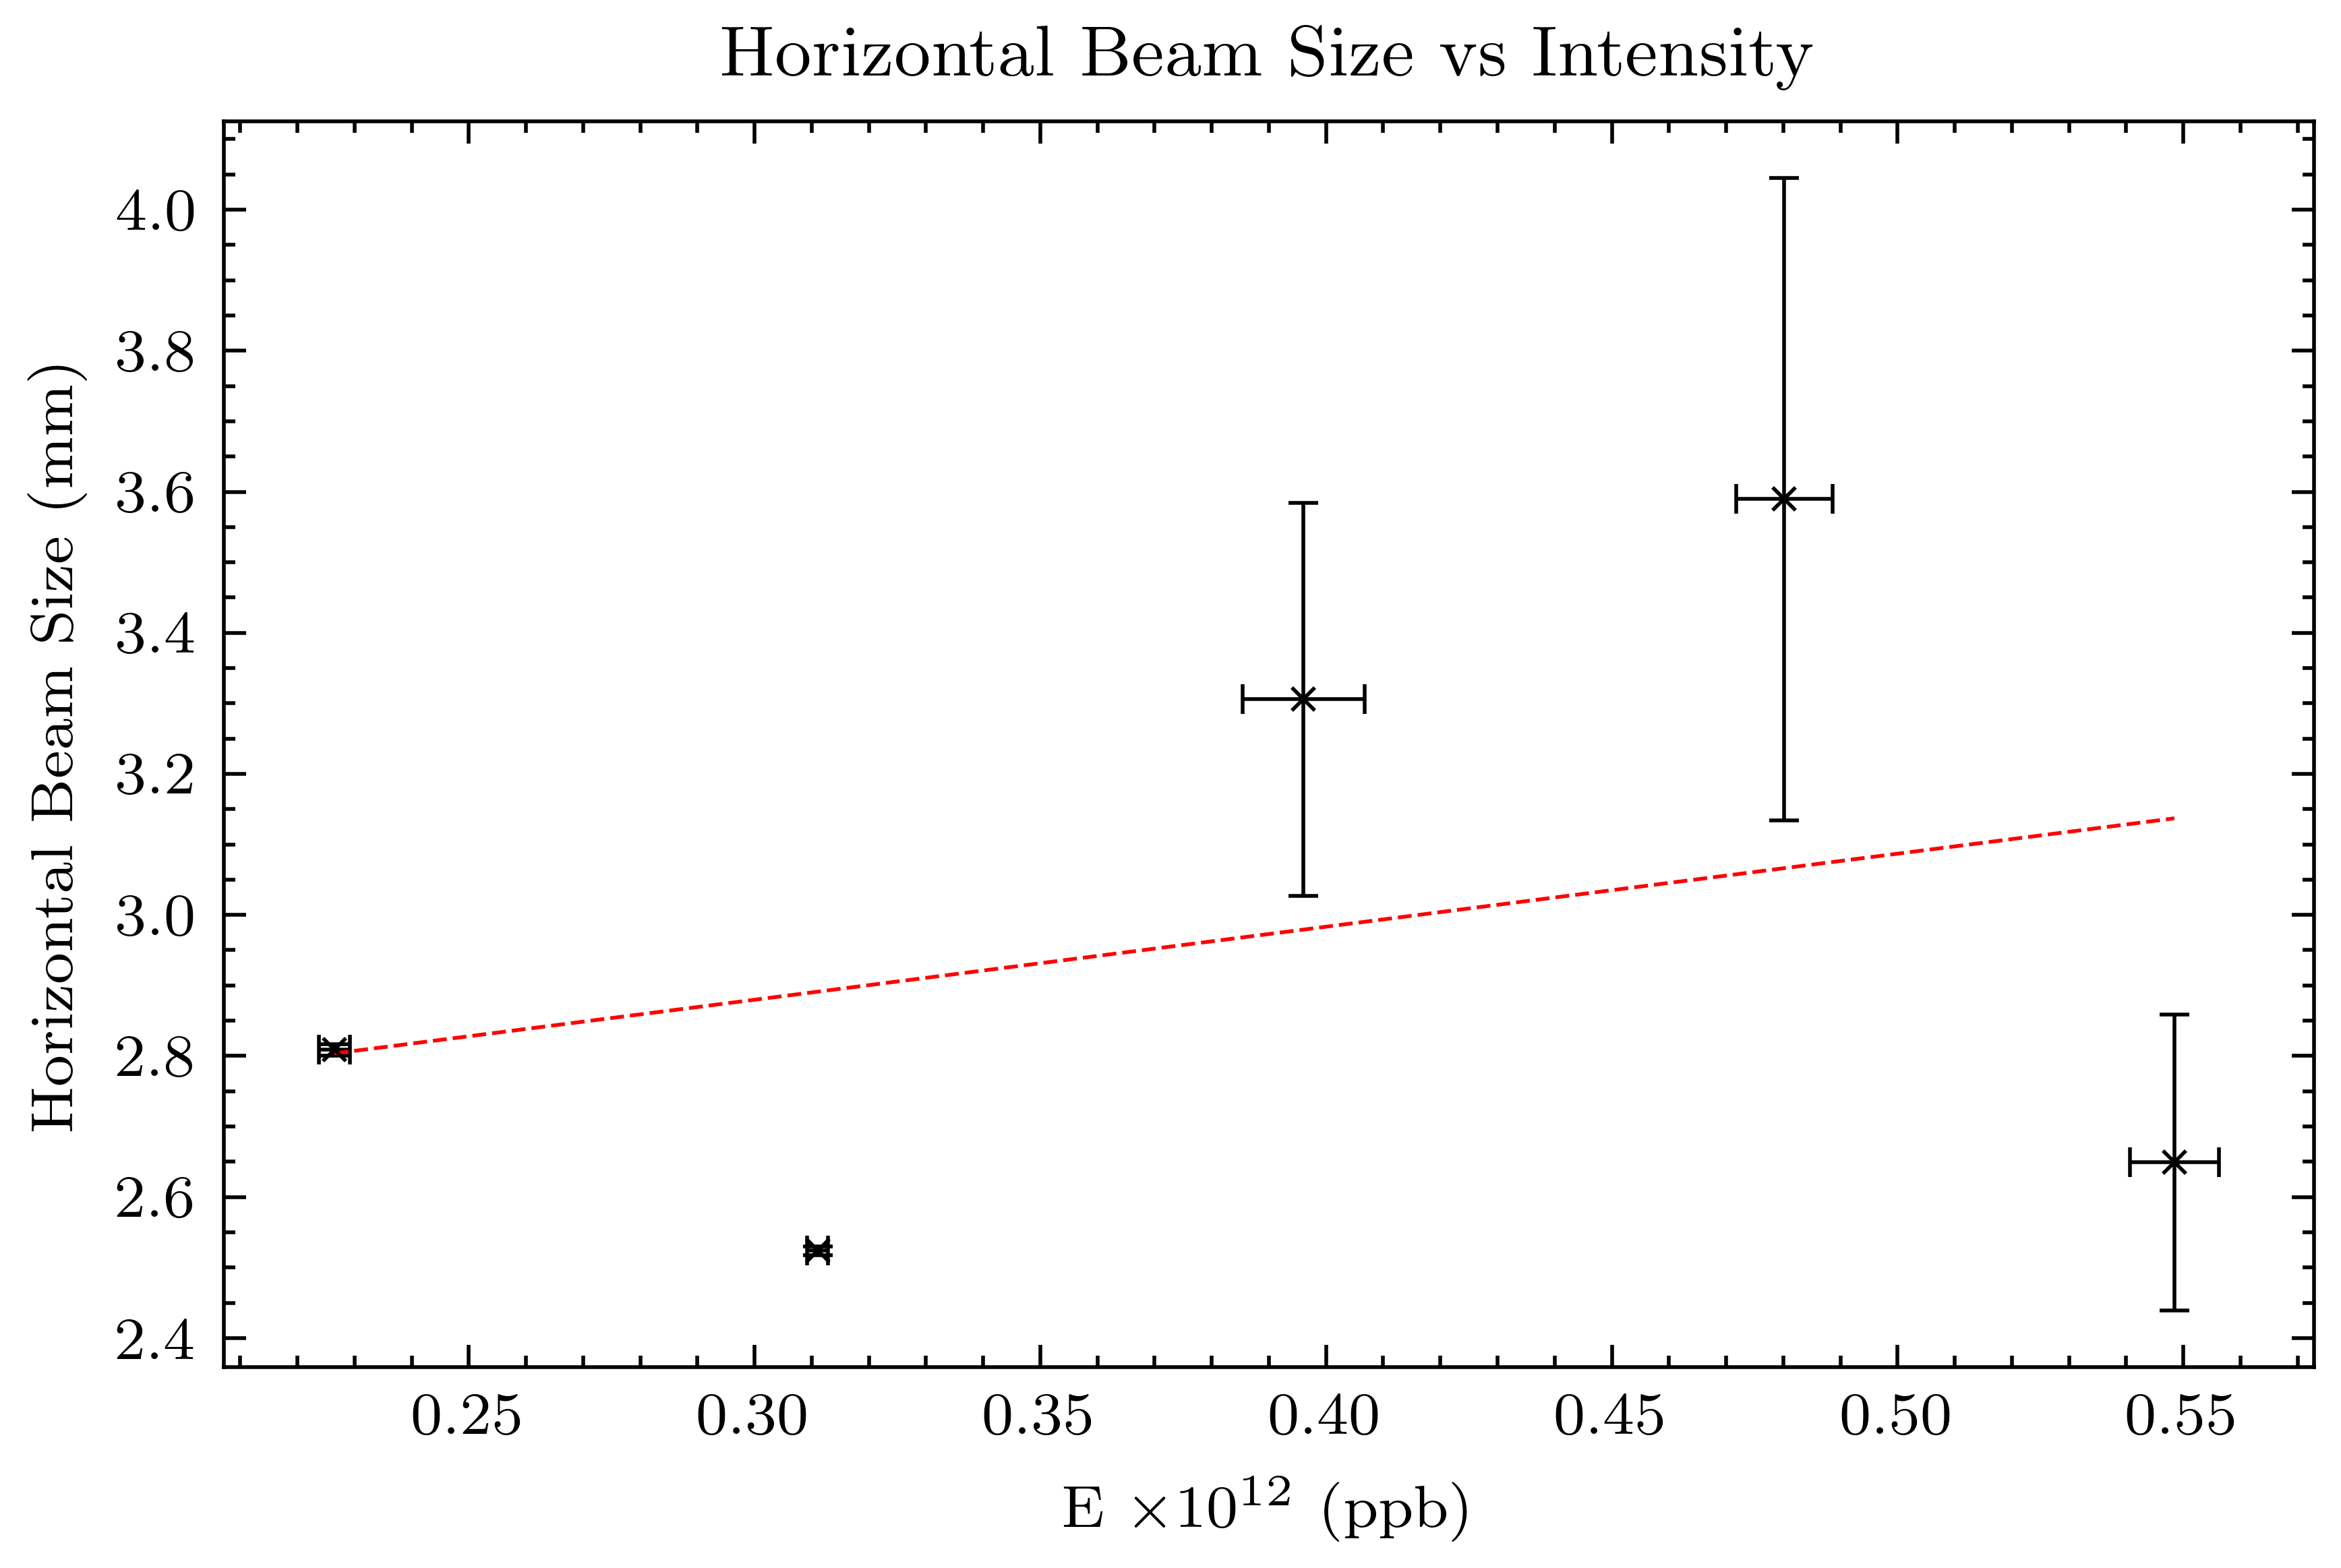

In [106]:
mcp_H(skip=["6.2"])

#### Vertical IPM

In [107]:
# Vertical IPM
# Gaussian function for fit
def gaussian(x, amplitude, mean, std_dev, c):
    return amplitude * np.exp(-(x - mean)**2 / (2 * std_dev**2)) + c

def linear_func(x, a, b):
    return a * x + b

def mcp_V(skip=[],debug=False):
    Num = 100
    booster_turns = [6,8,10,11,14]
    Beam_Width = np.zeros((len(booster_turns),5))
    Intensity = np.zeros((len(booster_turns),5))
    
    Intensity_Avg = np.zeros(len(booster_turns))
    Intensity_Std = np.zeros(len(booster_turns))
    Beam_Width_Avg = np.zeros(len(booster_turns))
    Beam_Width_Std = np.zeros(len(booster_turns))

    for t, turns in enumerate(booster_turns):
        for repeat in range(5):
            if (str(turns)+"."+str(repeat)) in skip:
                continue
            # Calculate average intensity in the 0.04s around 0.57s

            try:
                intensity_data = np.loadtxt(r'C:\\Users\bengl\Documents\summerIntern\data_studies\\' + str(turns) + r'turns'+str(repeat)+'_beam')
                mask = (intensity_data[0:,0] > 0.55) & (intensity_data[0:,0] < 0.59)
                Averaged_Intensity = np.mean(intensity_data[0:,1][mask])
                Intensity[t][repeat] = Averaged_Intensity
            except:
                pass
                #print('no intensity data for', turns, 'turns', repeat, 'repeat')

            try:
                data = np.load(r'C:\\Users\bengl\Documents\summerIntern\data_studies\\incoherent_tune_shift\\'+str(turns)+r'turns'+str(repeat)+'_V.npy')
                position = np.arange(0,len(data[Num]),1) * mcp_width
            except:
                continue

            # Remove the faulty sensor
            mask = data[Num] > -2000
            filtered = data[Num][mask]
            position_filtered = position[mask]

            # Remove first few MCP points as faulty
            mask = position_filtered > 2.1
            filtered = filtered[mask]
            position_filtered = position_filtered[mask]

            # Fit a gaussian to the peak
            p0 = [5000, 15*mcp_width, 10*mcp_width, 0]  # Initial guess for the parameters
            lower_bounds = [0, 0, 0, -1000]
            upper_bounds = [15000, 100*mcp_width, 30*mcp_width, 1000]
            bounds = (lower_bounds, upper_bounds)
            fit_params, _ = curve_fit(gaussian, position_filtered, filtered, p0=p0, bounds=bounds)
            amplitude_fit, mean_fit, std_dev_fit, c_fit = fit_params
            fitted_curve = gaussian(position_filtered, amplitude_fit, mean_fit, std_dev_fit, c_fit)

            # Plotting
            if debug==True:
                plt.plot(position_filtered, filtered, label='Fourier Transformed Data')
                plt.plot(position_filtered, fitted_curve, label='Fitted Curve')
                plt.title('Position with ' + str(turns) + ' Booster Turns')
                plt.xlabel('Position')
                plt.ylabel('Amplitude')
                plt.legend()
                plt.show()
            
            
            # In case only one data point
            Beam_Width_Avg[t] = std_dev_fit            
            
            Beam_Width[t][repeat] = std_dev_fit

            if debug==True:
                print(str(turns)+"."+str(repeat))
            
          
    
    
    # Remove rows if no data for that booster turn        
    # Create a boolean mask indicating which rows contain all zeros
    mask = np.any(Intensity != 0, axis=1)

    # Use the mask to select the rows without all zeros
    Intensity = Intensity[mask]
    Beam_Width = Beam_Width[mask]
    Beam_Width_Avg = Beam_Width_Avg[mask]
    Beam_Width_Std = Beam_Width_Std[mask]
    Intensity_Avg = Intensity_Avg[mask]
    Intensity_Std = Intensity_Std[mask]

    for i in range(Intensity.shape[0]):
        I_list = Intensity[i,:][Intensity[i,:]>0]
        if len(I_list) == 1:
            continue
        else:
            Intensity_Std[i] = np.std(I_list)
            Intensity_Avg[i] = np.mean(I_list)

            list = Beam_Width[i,:][Beam_Width[i,:]>0]
            Beam_Width_Avg[i] = np.mean(list)
            Beam_Width_Std[i] = np.std(list)
    
    # Set the STD of the Intensity to the maximum of the others (if only one data point)
    for i in range(Intensity.shape[0]):
        I_list = Intensity[i,:][Intensity[i,:]>0]
        if len(I_list) == 1:
            print("Using max intensity error of others for turns", booster_turns[i])
            Intensity_Std[i]=max(Intensity_Std)
            Intensity_Avg[i]=I_list[0]

        list = Beam_Width[i,:][Beam_Width[i,:]>0]
        if len(list)==1:
            print("Using max frequency error of others for turns", booster_turns[i])
            Beam_Width_Std[i]=max(Beam_Width_Std)
            Beam_Width_Avg[i]=list[0]
          
    
    params, _ = curve_fit(linear_func, Intensity_Avg, Beam_Width_Avg)
    # Extract the fitted parameters
    a, b = params
    # Plot
    
    plt.style.use(['science','ieee'])
    fig, ax = plt.subplots(figsize=(5,3), dpi=800)
    plt.xlabel(r'E $\times 10^{12}$ (ppb)')
    plt.ylabel('Vertical Beam Size (mm)')
    plt.title('Vertical Beam Size vs Intensity')
    plt.errorbar(Intensity_Avg,Beam_Width_Avg,xerr=Intensity_Std,yerr=Beam_Width_Std, fmt='x', markersize=3, markeredgewidth=0.5, ecolor='black', capsize=2, elinewidth=0.5, capthick=0.5)
    plt.plot(Intensity_Avg,a*np.array(Intensity_Avg)+b, label='Linear Fit', color='red', linewidth=0.5)
    plt.show()


Using max intensity error of others for turns 6
Using max frequency error of others for turns 6


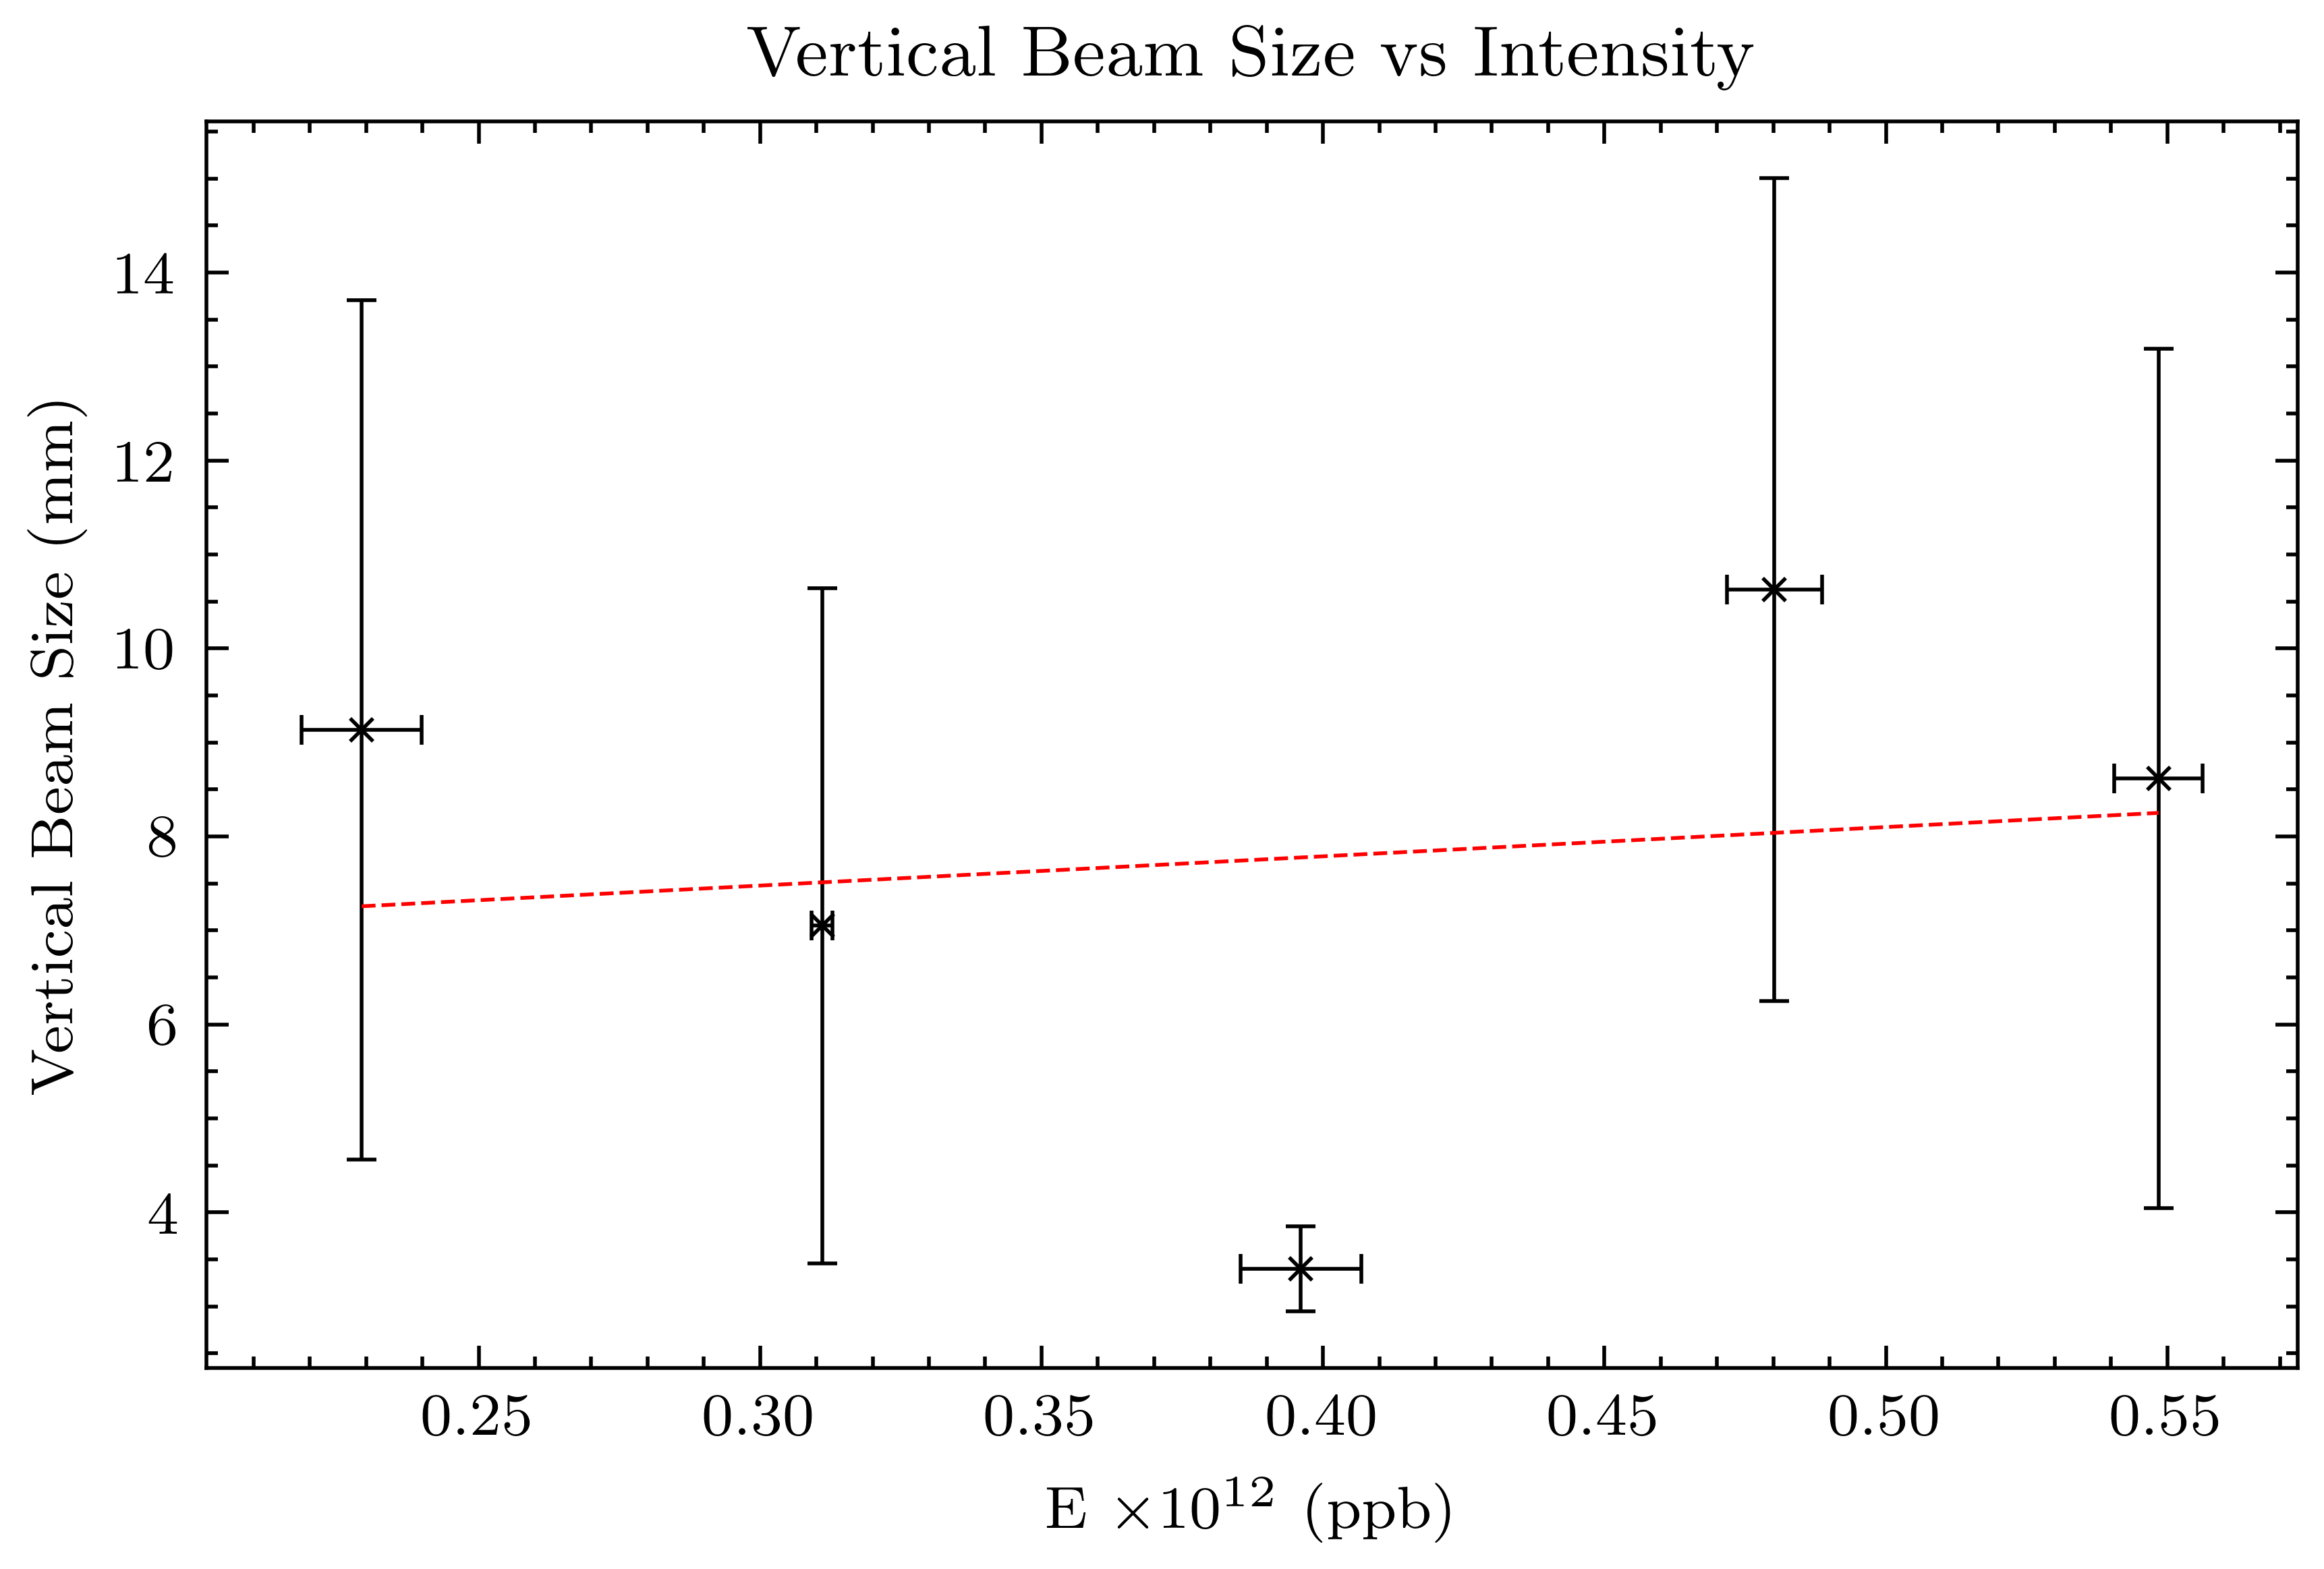

In [108]:
mcp_V(skip=["6.2","6.1"])